In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt 
import pandas as pd
from scipy import signal
from scipy.interpolate import PchipInterpolator
import glob
import os


def hpts_writer(hpts_file,Nx=10,Ny=10,Nz=10):
    u,v,w = np.loadtxt(hpts_file,usecols=((1,2,3)),unpack=True)

    sp,s,sy= (Ny*Nz,Nx),(Nz,Ny,Nx),(Nz,Ny)

    u_2D, v_2D, w_2D = u.reshape(sp,order='F'),v.reshape(sp,order='F'),w.reshape(sp,order='F')

    # initialize arrays #
    u_3D,v_3D,w_3D = np.zeros(s),np.zeros(s),np.zeros(s)

    for idx in range(Nx):
        temp1,temp2,temp3 = u_2D[:,idx],v_2D[:,idx],w_2D[:,idx]
        u_3D[:,:,idx],v_3D[:,:,idx],w_3D[:,:,idx] = temp1.reshape(sy,order='F'), \
        temp2.reshape(sy,order='F'),temp3.reshape(sy,order='F')
        
        
    return u_3D, v_3D, w_3D

def time_avg(Pathname,filebase,Nx=10,Ny=10,Nz=10):
    
    temp = sorted(glob.glob(Pathname+'/*'))
    N_file = len(temp) 
    print(N_file)
    u_avg = np.zeros((Nz,Ny,Nx))
    for i in range(N_file):
        file = filebase+'_%04d.out'%(i)
        Path = os.path.join(Pathname,file)
        u,_,_ = hpts_writer(Path,Nx=Nx,Nz=Nz,Ny=Ny)
        u_avg += u
    u_avg/=float(N_file)

    return u_avg

def z_avg(data_u):
    import numpy as np
    m,n,p = data_u.shape
    const=1.0/float(m)
    data_avg_u = np.zeros((n,p))
    
    for idz in range(m):
        data_avg_u[:,:]+= data_u[idz,:,:]
        
    data_avg_u *= const
    
    return data_avg_u

def signal_1D_refine(up,Lx,Nx):
    x = np.linspace(0.0,Lx,Nx,endpoint=True)
    x_int = np.linspace(0.0,Lx,64*(Nx-1)+1,endpoint=True)
    up_1D_func = PchipInterpolator(x,up)
    up_i = up_1D_func(xint)
    
    return x_int,up_i
    

def windowed_correlation(u_signal,x,window_size):
    N_signal = len(u_signal)
    
    if(window_size > N_signal):
        raise(ValueError("window size should be smaller than length of the signal"))

    ## Default - 50% overlap of the window-size
    
    N_window_signal = (N_signal-1)//window_size
    if(N_window_signal != int((N_signal-1)/window_size)):
        raise(ValueError(" Window signal should evenly divide "))
      
    Nws = int(2*N_window_signal-2) # make it twice for 50% overlap
    x_bin,up_lags,up = [],[],[]
    
    for i in range(Nws):
        
        begin = int(i*window_size//2)
        end =   int(i*window_size//2+window_size)
        
        us = u_signal[begin:end]
        up_ = signal.correlate(us,us)
        up_ /= np.max(up_)
        up.append(up_)
        up_lags.append(signal.correlation_lags(len(us),len(us)))
        x_bin.append(0.5*(x[begin]+x[end]))
    return x_bin,up,up_lags
    
def time_z_avg_correlation(up_signal,Lx,window_size,iy):
    nz,ny,nx = np.size(up_signal)
    xi,up0 = signal_1D_refine(up[0,0,:],Lx,nx)
    nxi = len(up0)
    upi_signal = np.zeros((nz,nxi))

    for i in range(nz):
        _,upi = signal_1D_refine(up[iz,iy,:],Lx,nx)
        upi_signal[iz,:] = upi
        
    x_bin,temp,u_Lag = windowed_correlation(upi_signal[0,:],window_size) # dummy call
    u_avg_corr = np.array(temp)
    Nx_bin, N_lag = np.size(u_avg_corr)
    u_corr_window = np.zeros((nz,Nx_bin,N_lag))
    
    
    for iz in range(nz):
        _,u_corr,_ = windowed_correlation(up_signal[iz,iy,:],window_size)
        u = np.array(u_corr)
        ucorr_window[iz,:,:] = u[:,:]
                
## Perform z average of the correlation window

    u_avg_corr = z_avg(u_corr_window)
    
    return u_avg_corr
            
        
        
        
        
        
    

In [2]:
Path = 'DATA_TSR_5_sx_7D'
file = sorted(glob.glob(Path+'/*'))
print(len(file))


326


(129, 5, 513)
10


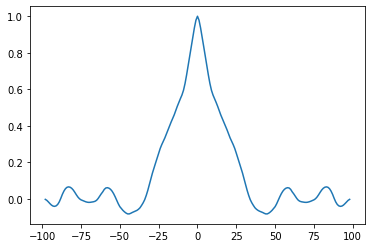

In [20]:
from scipy import signal
from scipy.interpolate import PchipInterpolator
hpts_file = 'DATA_TSR_5_sx_7D/wave_0000.out'

u,v,w = hpts_writer(hpts_file,Nx=513,Nz=129,Ny=5)
print(np.shape(u))
uavg = time_avg('DATA_TSR_5_sx_7D','wave',Nx=513,Ny=5,Nz=129)
up = u-uavg # fluctuation in u



x = np.linspace(0.0,6.0*np.pi,513,endpoint=True)

u_1D = u[64,2,:]
u_1D_func = PchipInterpolator(x,u_1D)

xint = np.linspace(0.0,6.0*np.pi,4096,endpoint=True)
u_1Di = u_1D_func(xint)

#plt.figure(figsize=(28,4))
#plt.plot(xint,u_1Di,linewidth=3.0,linestyle='-')
#plt.plot(x,u_1D,linestyle=None,marker='o')


corr = signal.correlate(u[64,2,1:100]-uavg[64,2,1:100],u[64,2,1:100]-uavg[64,2,1:100])
lags = signal.correlation_lags(len(u[64,2,1:100]), len(u[64,2,1:100]))

corr /= np.max(corr)
plt.plot(lags,corr)




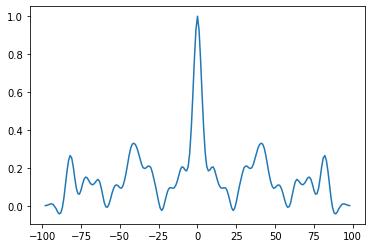

In [9]:
corr = signal.correlate(u[64,2,101:200]-uavg[64,2,101:200],u[64,2,101:200]-uavg[64,2,101:200])
lags = signal.correlation_lags(len(u[64,2,1:100]), len(u[64,2,1:100]))

corr /= np.max(corr)
plt.plot(lags,corr)


In [6]:
## Correlation ##
print(np.size(corr))

1025


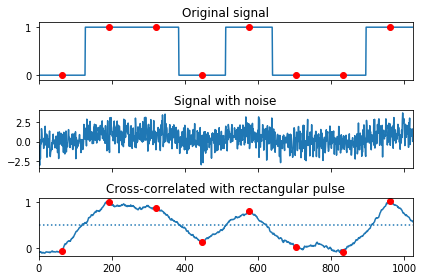

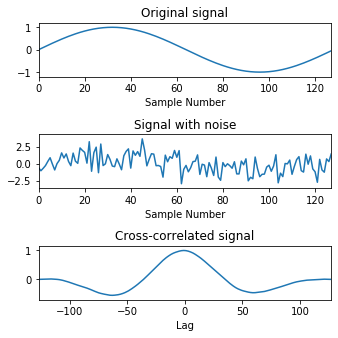

Home\Desktop\Friend


0000
0001
0002
0003
0004
0005
0006
0007
0008
0009


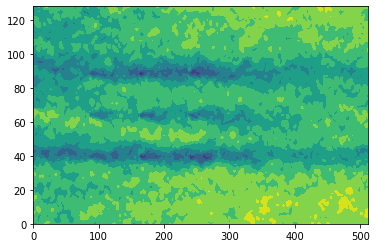

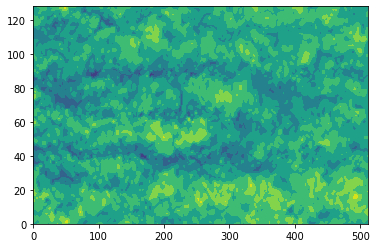

8193


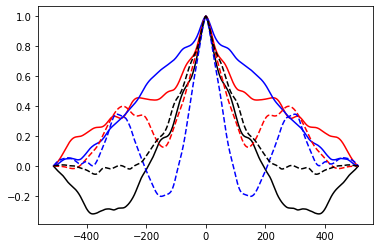

In [107]:
Nb = 40
u_1D = u[Nb,3,:]
uavg_1D = uavg[Nb,3,:]
x_int,up = signal_1D_refine(u_1D,uavg_1D,Lx=6.0*np.pi,Nx=513)
print(len(x_int))
x_bin, up, up_lags = windowed_correlation(up,xint,512)
plt.plot(up_lags[0],up[0],'-r')
plt.plot(up_lags[1],up[1],'-b')
plt.plot(up_lags[2],up[2],'-k')
plt.plot(up_lags[3],up[3],'--r')
plt.plot(up_lags[4],up[4],'--b')
plt.plot(up_lags[5],up[5],'--k')



In [74]:
8192//128

64

In [10]:
import numpy as np
D = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]
E = np.array(D)

print(D,E)
print(D[3][2],E[3,2])

[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]] [[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]
12 12
